In [3]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from scipy.ndimage import gaussian_filter
from torch.utils.data import DataLoader, Dataset
import os
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt


In [4]:
this_dir = os.getcwd()
data_dir = os.path.join(this_dir, 'dataset')
file_name = 'walking_cjj.csv'
file_path = os.path.join(data_dir, file_name)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

['left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z']


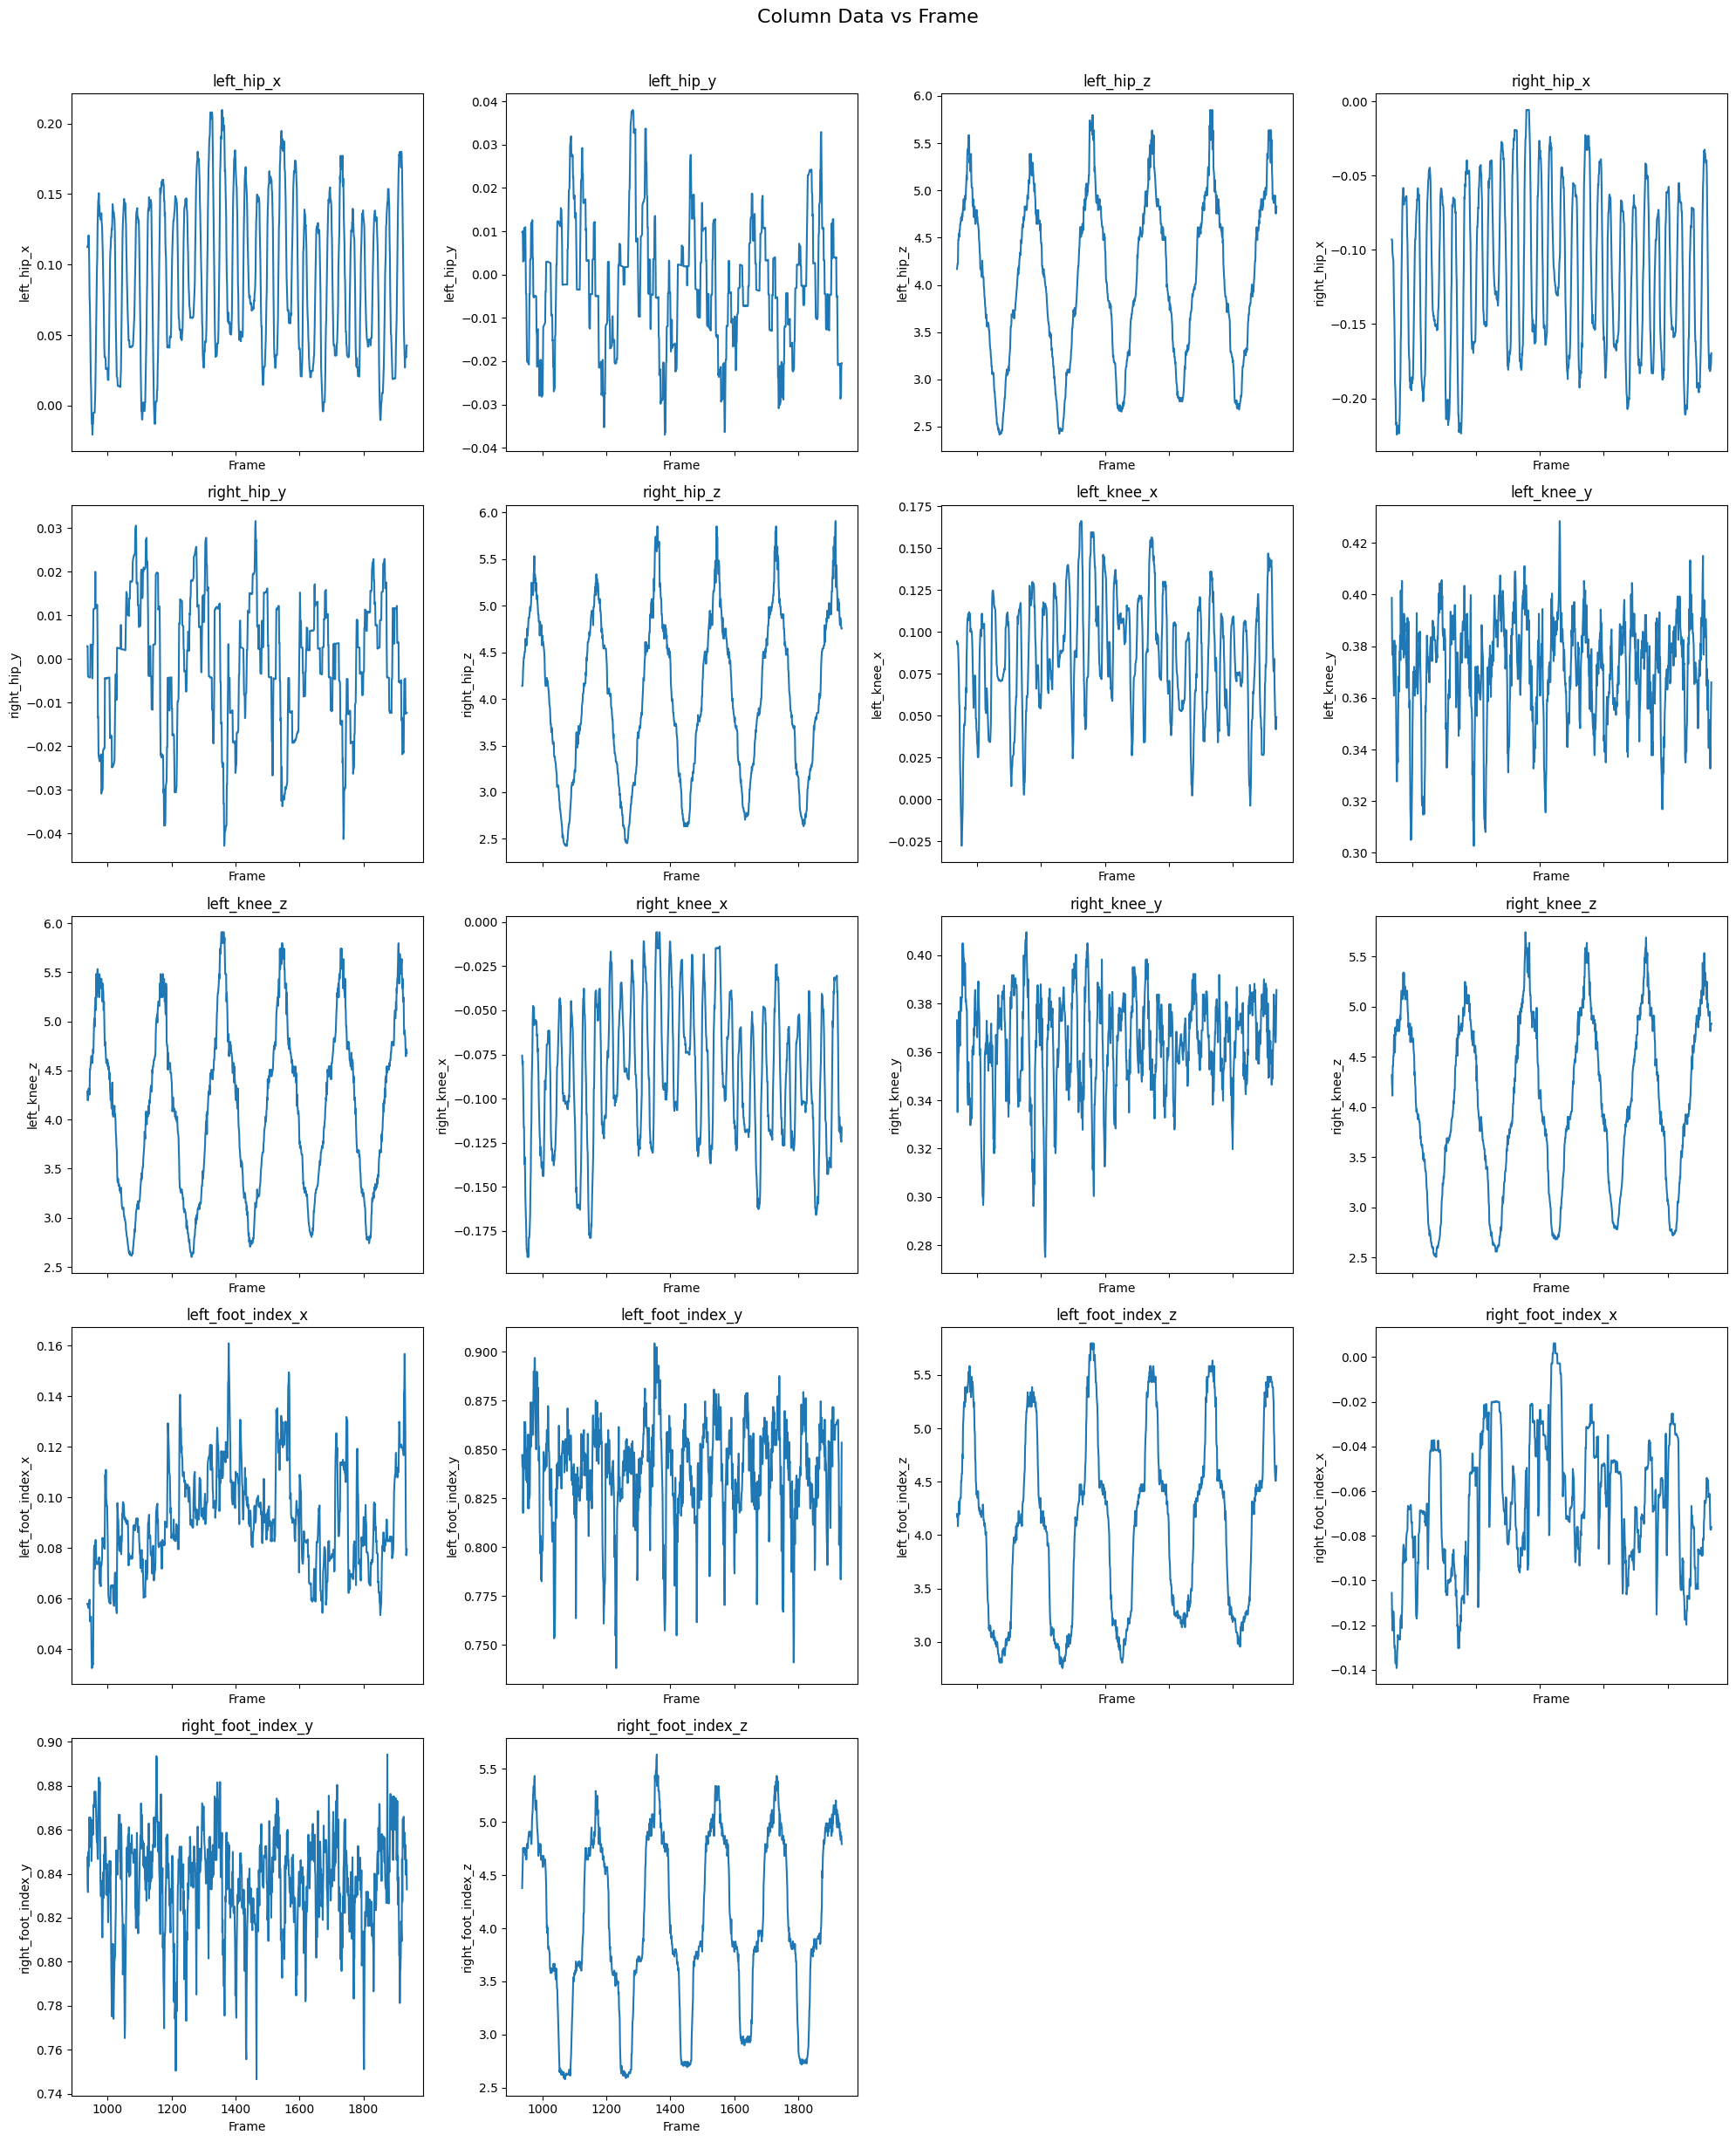

In [11]:
data = pd.read_csv(file_path)
# Get the data length
data_length = len(data)
# data_length
# Get the center 5000 data
total_data = 5500
data = data.iloc[int(data_length / 2) - int(total_data / 2): int(data_length / 2) + int(total_data / 2)]
# backup the original data
data_original = data.copy()

# get the column names in list
column_names = data.columns.tolist()
column_names.remove('Timestamp')
column_names.remove('Frame')
column_names.remove('Matrix_0')
column_names.remove('Matrix_1')
# remove all head elbow heel
# ['head_x', 'head_y', 'head_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'left_foot_index_x', 'left_foot_index_y', 'left_foot_index_z', 'right_foot_index_x', 'right_foot_index_y', 'right_foot_index_z']
column_names = [x for x in column_names if 'head' not in x and 'elbow' not in x and 'heel' not in x and 'shoulder' not in x]
print(column_names)


# plot each column vs Frame number in a figure in different subplots
num_columns = len(column_names)
num_rows = math.ceil(math.sqrt(num_columns))
num_cols = math.ceil(num_columns / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharex=True)
fig.suptitle('Column Data vs Frame', fontsize=16)

axes = axes.flatten()

for i, column_name in enumerate(column_names):
    axes[i].plot(data_original['Frame'][:1000], data_original[column_name][:1000])
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel(column_name)
    axes[i].set_title(column_name)

# Hide any unused subplots
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for the suptitle
plt.show()


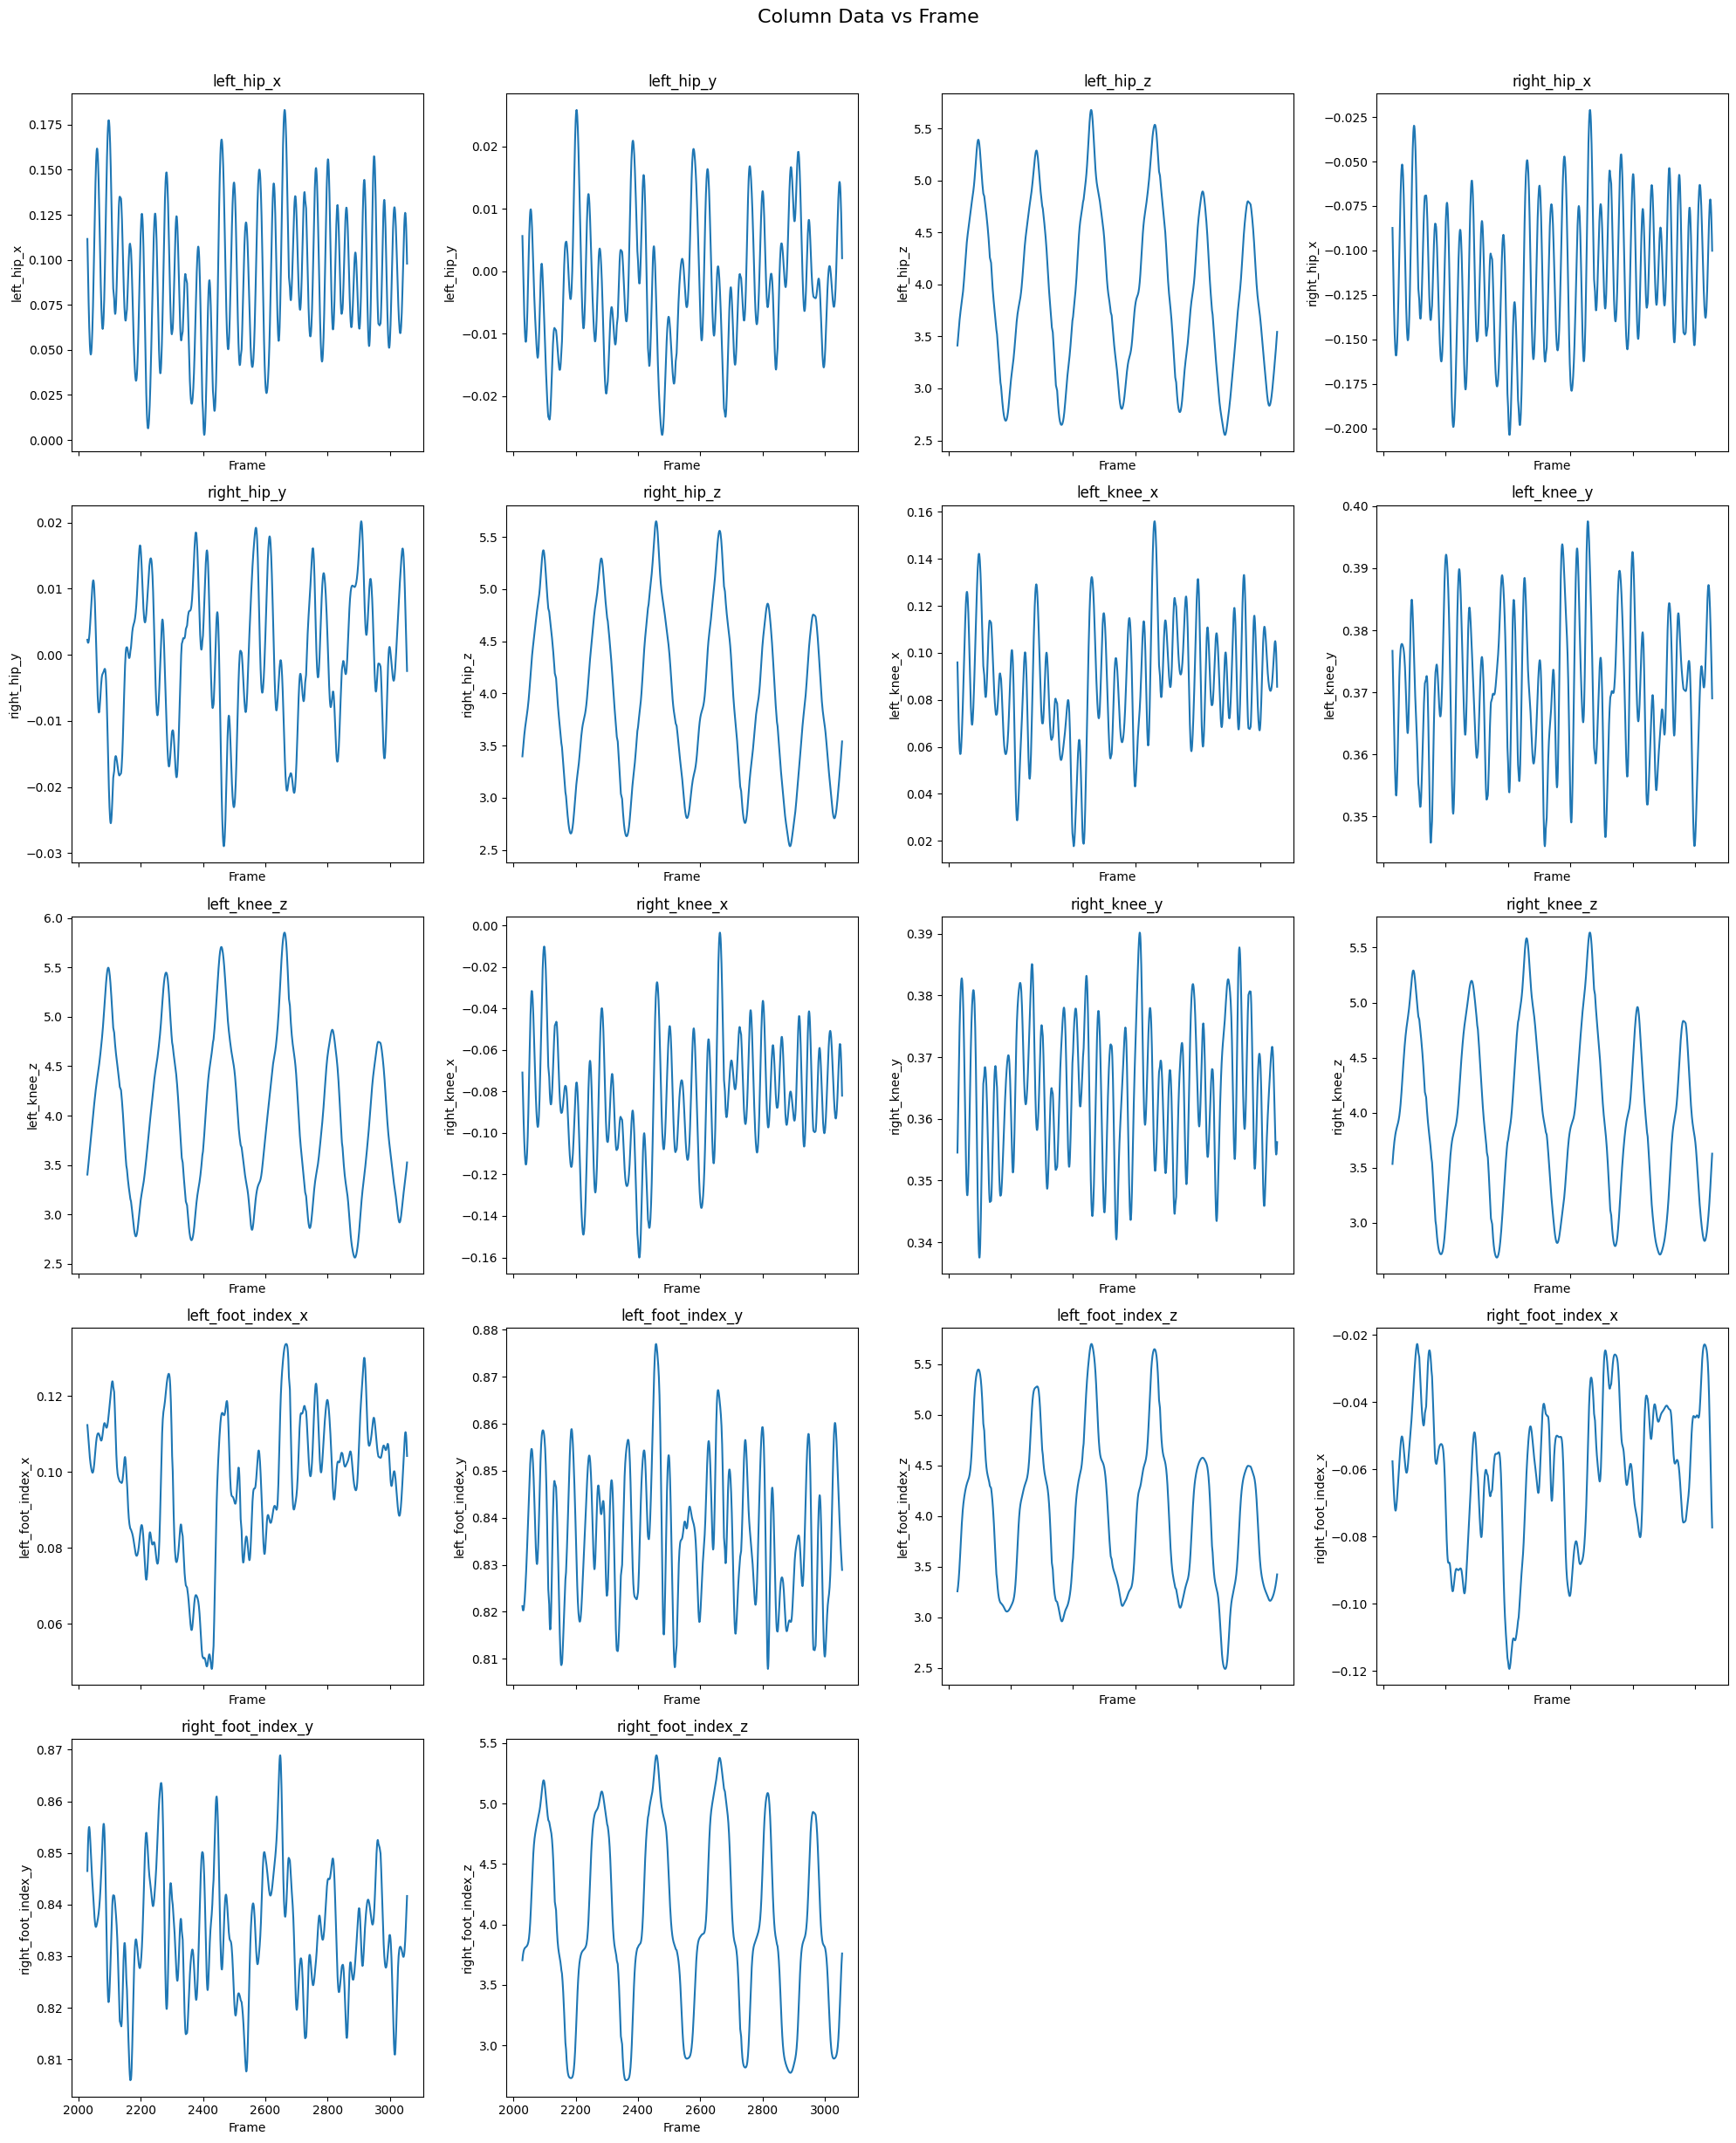

,Timestamp,Frame,head_x,head_y,head_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,...,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z,Matrix_0,Matrix_1
1113,1.727034e+09,1113,-0.166972,-0.776988,3.666,0.020235,-0.562078,3.644,-0.334156,-0.544056,...,0.774015,3.804,0.067615,0.829739,3.766277,-0.101041,0.847664,3.651663,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,529,0,0,0,0,0,0,0,0,0,0,0,0,0,559,0,..."
1114,1.727034e+09,1114,-0.160929,-0.776988,3.666,0.020479,-0.568864,3.688,-0.338191,-0.550626,...,0.767744,3.804,0.067069,0.830595,3.812068,-0.100927,0.846574,3.655640,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,518,0,0,548,0,0,0,0,0,0,0,0,0,0,0,0,..."
1115,1.727034e+09,1115,-0.162905,-0.786526,3.711,0.026400,-0.565471,3.666,-0.336173,-0.547341,...,0.772588,3.828,0.066771,0.831529,3.852277,-0.100685,0.845484,3.659832,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,559,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
1116,1.727034e+09,1116,-0.160929,-0.776988,3.666,0.026724,-0.572412,3.711,-0.338191,-0.550626,...,0.769132,3.780,0.066746,0.832565,3.887121,-0.100341,0.844466,3.664894,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
1117,1.727034e+09,1117,-0.156788,-0.786526,3.711,0.032841,-0.572412,3.711,-0.338325,-0.560927,...,0.767744,3.804,0.067008,0.833722,3.917111,-0.099913,0.843582,3.671619,"0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0,0,0,0,0,0,0,0,541,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1113 to 6280
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Timestamp           5000 non-null   float64
 1   Frame               5000 non-null   int64  
 2   head_x              5000 non-null   float64
 3   head_y              5000 non-null   float64
 4   head_z              5000 non-null   float64
 5   left_shoulder_x     5000 non-null   float64
 6   left_shoulder_y     5000 non-null   float64
 7   left_shoulder_z     5000 non-null   float64
 8   right_shoulder_x    5000 non-null   float64
 9   right_shoulder_y    5000 non-null   float64
 10  right_shoulder_z    5000 non-null   float64
 11  left_elbow_x        5000 non-null   float64
 12  left_elbow_y        5000 non-null   float64
 13  left_elbow_z        5000 non-null   float64
 14  right_elbow_x       5000 non-null   float64
 15  right_elbow_y       5000 non-null   float64
 16  right_el

None

,Timestamp,Frame,head_x,head_y,head_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.727034e+09,3720.709000,-0.026942,-0.789322,4.016113,0.168090,-0.583567,4.205972,-0.207569,-0.568392,...,4.121553,-0.047266,0.744964,4.086135,0.092195,0.838630,4.051405,-0.066866,0.836824,4.034389
std,2.025901e+02,1483.273382,0.088548,0.034564,0.850524,0.084537,0.070495,1.058963,0.077822,0.033972,...,0.814149,0.024017,0.025360,0.802663,0.018794,0.014676,0.792335,0.022765,0.012117,0.773957
min,1.727034e+09,1113.000000,-0.219988,-0.918684,2.396000,0.000000,-1.200256,0.000000,-0.396393,-0.664966,...,2.590000,-0.128326,0.616443,2.658000,0.042767,0.800139,2.488900,-0.134568,0.805948,2.618634
25%,1.727034e+09,2447.750000,-0.107672,-0.816199,3.272000,0.091959,-0.612287,3.362000,-0.277739,-0.596962,...,3.326000,-0.062442,0.730731,3.419000,0.079692,0.827688,3.299100,-0.082587,0.828227,3.391670
50%,1.727034e+09,3732.500000,-0.031132,-0.784694,3.952000,0.163080,-0.575113,4.140000,-0.211356,-0.565179,...,4.197000,-0.048152,0.747347,4.030000,0.092055,0.838337,4.093964,-0.067291,0.836045,3.961211
75%,1.727035e+09,5005.250000,0.055208,-0.762056,4.681000,0.241015,-0.546927,4.988000,-0.133978,-0.543366,...,4.646000,-0.030107,0.762088,4.869000,0.106086,0.848983,4.642599,-0.050187,0.844818,4.775917
max,1.727035e+09,6280.000000,0.182446,-0.716686,6.147000,0.507357,0.000000,9.509001,-0.024440,-0.486051,...,5.909000,0.044514,0.820670,5.635000,0.135836,0.891456,5.802264,0.002632,0.874704,5.505563


Data shape: (5000, 43)


In [66]:
# remove the outliers data
z_scores = data[column_names].apply(zscore)
threshold = 3
data = data[(z_scores.abs() < threshold).all(axis=1)]

# filter the data
# sigma is the standard deviation of the Gaussian kernel

# midfilt
# for column in column_names:
#     data[column] = medfilt(data[column], kernel_size=3)

for column_name in column_names:
    data[column_name] = gaussian_filter(data[column_name], sigma=5)

num_columns = len(column_names)
num_rows = math.ceil(math.sqrt(num_columns))
num_cols = math.ceil(num_columns / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharex=True)
fig.suptitle('Column Data vs Frame', fontsize=16)

axes = axes.flatten()

for i, column_name in enumerate(column_names):
    left = 1000
    right = 2000
    axes[i].plot(data['Frame'][left:right], data[column_name][left:right])
    # axes[i].plot(data_original['Frame'][left:right], data_original[column_name][left:right])
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel(column_name)
    axes[i].set_title(column_name)

# Hide any unused subplots
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for the suptitle
plt.show()


# keep the 5000 data
data_length = len(data)
total_data = 5000
data = data.iloc[int(data_length / 2) - int(total_data / 2): int(data_length / 2) + int(total_data / 2)]

display(data.head())
display(data.info())
display(data.describe())

# shape of the data
data_shape = data.shape
print(f"Data shape: {data_shape}")


In [67]:
# Normalize the data
data_matrix_0 = data['Matrix_0']
data_matrix_1 = data['Matrix_1']

matrix_0 = []
matrix_1 = []

# convert the data to matrix
for data in data_matrix_0:
    temp = np.array(data.split(','), dtype=np.float32).reshape(33, 15)
    temp = temp[:, 2:-2]
    matrix_0.append(temp)

for data in data_matrix_1:
    temp = np.array(data.split(','), dtype=np.float32).reshape(33, 15)
    temp = temp[:, 2:-2]
    matrix_1.append(temp)

# print the shape of the matrix
print(f"Matrix 0 shape: {np.array(matrix_0).shape}")
print(f"Matrix 1 shape: {np.array(matrix_1).shape}")

Matrix 0 shape: (5000, 33, 11)
Matrix 1 shape: (5000, 33, 11)
